# Code for executing in Colab

In [ ]:
!git clone https://github.com/cico-rial/overcooked_ai.git

Cloning into 'overcooked_ai'...
remote: Enumerating objects: 8079, done.
remote: Counting objects: 100% (1180/1180), done.
remote: Compressing objects: 100% (204/204), done.
remote: Total 8079 (delta 1040), reused 980 (delta 976), pack-reused 6899 (from 4)
Receiving objects: 100% (8079/8079), 567.43 MiB | 23.15 MiB/s, done.
Resolving deltas: 100% (4542/4542), done.
Updating files: 100% (448/448), done.


In [ ]:
!sudo apt-get update -y
!sudo apt-get install python3.10 python3.10-dev python3.10-distutils -y
!wget https://bootstrap.pypa.io/get-pip.py
!python3.10 get-pip.py

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,721 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,994 kB]
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,246 kB]
Get:13 http://archive.ubuntu.com/u

In [ ]:
import os
os.kill(os.getpid(), 9)

In [ ]:
%cd overcooked_ai
# !ls
!python3.10 -m pip install -e .

/content/overcooked_ai
Obtaining file:///content/overcooked_ai
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 139.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 128.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 831.9/831.9 kB 51.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 89.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 167.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 148.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 99.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 148.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 67.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import sys
sys.path.append('/content/overcooked_ai/src')

# Imports

In [507]:
from overcooked_ai_py.mdp.overcooked_env import OvercookedEnv, Overcooked
from overcooked_ai_py.mdp.overcooked_mdp import OvercookedGridworld, OvercookedState
from overcooked_ai_py.visualization.state_visualizer import StateVisualizer
from overcooked_ai_py.mdp.actions import Action
from overcooked_ai_py.agents.agent import Agent, AgentPair, RandomAgent
from overcooked_ai_py.agents.benchmarking import AgentEvaluator
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Activation, Concatenate
from tensorflow.keras.models import Model
from tqdm.notebook import tqdm
import scipy.stats
from typing import Tuple, List, Dict
import os

In [508]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

TensorFlow version: 2.19.0
Num GPUs Available: 0


# Useful classes

Policy class: NN for computing the probability distribution of the actions to take.

In [509]:
class Policy(Model):
    def __init__(self, input_shape, num_actions, optimizer, epsilon = 0.05):
        super().__init__()
        self.input_shape = input_shape
        self.num_actions = num_actions
        self.optimizer = optimizer
        self.epsilon = epsilon
        self.input_a = Input(shape=(self.input_shape))
        self.input_b = Input(shape=(self.input_shape))
        # self.concatenate_inputs = Concatenate()
        self.dense_1 = layers.Dense(128, activation='tanh')
        self.dense_2 = layers.Dense(256, activation='tanh')
        self.dense_3 = layers.Dense(256, activation='tanh')
        self.dense_4 = layers.Dense(128, activation='tanh')
        self.policy_a = layers.Dense(self.num_actions, activation='softmax', name="policy_a")
        self.policy_b = layers.Dense(self.num_actions, activation='softmax', name="policy_b")
        self.build_model()

    # def preprocess(self, obs):
    #     agent_1_obs = obs['both_agent_obs'][0]
    #     agent_2_obs = obs['both_agent_obs'][1]
    #     return (tf.expand_dims(agent_1_obs, axis=0), tf.expand_dims(agent_2_obs, axis=0))
    
    def preprocess(self, obs):
        if isinstance(obs, Tuple):
            obs = [obs] # to handle the case where obs_batch is a single observation

        obs_1, obs_2 = zip(*obs)
        obs_batch = tf.concat([tf.stack(obs_1), tf.stack(obs_2)], axis=-1)
        return obs_batch


    def call(self, obs, training=False):
        x = self.preprocess(obs)
        # x = self.concatenate_inputs(x)
        x = self.dense_1(x)
        x = self.dense_2(x)
        x = self.dense_3(x)
        x = self.dense_4(x)
        policy_a = self.policy_a(x)
        policy_b = self.policy_b(x)
        return (policy_a, policy_b)

    def build_model(self):
        # computing a forward pass in order to automatically build the model
        dummy_input = (
            tf.zeros((1, 96)),
            tf.zeros((1, 96))
        )
        _ = self(dummy_input)

    def train_step(self, delta, obs: Tuple, action: Tuple[int,int]):
        # update t with t + alpha_t*delta*grad_pi^(A|S) where A is the action taken before reaching St+1
        with tf.GradientTape() as tape:
            pi = self.call(obs, training=True)
            log_pi = tf.math.log(pi)
            pi_a = log_pi[0][..., action[0]] + log_pi[1][..., action[1]] # π(A|S), computing the sum of the probability of the best actions

        grad_pi_a = tape.gradient(pi_a, self.trainable_weights)
        processed_gradient = [-tf.squeeze(delta)*grad for grad in grad_pi_a]
        self.optimizer.apply_gradients(zip(processed_gradient, self.trainable_weights))
    
    def train_batch(self, deltas_batch: tf.Tensor, obs_batch, actions_batch):
        # update t with t + alpha_t*delta*grad_pi^(A|S) where A is the action taken before reaching St+1
        with tf.GradientTape() as tape:
            pi = self.call(obs_batch, training=True)
            log_pi = tf.math.log(pi)
            pi_a1 = tf.gather(log_pi[0], actions_batch[:, 0], axis=1, batch_dims=1)
            pi_a2 = tf.gather(log_pi[1], actions_batch[:, 1], axis=1, batch_dims=1)
            if tf.rank(deltas_batch) == 1:
                deltas_batch = tf.stack((deltas_batch,deltas_batch), axis=1)
            stacked_pi_a = tf.stack((pi_a1,pi_a2), axis=1)
            # Now compute the weighted sum over the batch
            pi_a = -tf.reduce_sum(deltas_batch*stacked_pi_a)           

        grad_pi_a = tape.gradient(pi_a, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grad_pi_a, self.trainable_weights))

    def train_batch_PPO(self, deltas_batch: tf.Tensor, obs_batch, actions_batch, old_policy):
        if tf.rank(deltas_batch) == 1:
            deltas_batch = tf.expand_dims(deltas_batch, axis=1)
        with tf.GradientTape() as tape:
            pi = self.call(obs_batch, training=True)
            old_pi = old_policy.call(obs_batch)
            pi_ratio_1 = pi[0] / old_pi[0] + 1e-8 # to avoid numerical instability
            pi_ratio_2 = pi[1] / old_pi[1] + 1e-8 # to avoid numerical instability
            pi_clipped_ratio_1 = tf.clip_by_value(pi_ratio_1, 1 - self.epsilon, 1 + self.epsilon)
            pi_clipped_ratio_2 = tf.clip_by_value(pi_ratio_2, 1 - self.epsilon, 1 + self.epsilon)
            pi_ratio_advantage_1 = pi_ratio_1*deltas_batch
            pi_ratio_advantage_2 = pi_ratio_2*deltas_batch
            pi_clipped_ratio_advantage_1 = pi_clipped_ratio_1*deltas_batch
            pi_clipped_ratio_advantage_2 = pi_clipped_ratio_2*deltas_batch
            L = 0
            for i in range(len(actions_batch)):
                L += min(pi_ratio_advantage_1[i][actions_batch[i][0]], pi_clipped_ratio_advantage_1[i][actions_batch[i][0]])
                L += min(pi_ratio_advantage_2[i][actions_batch[i][1]], pi_clipped_ratio_advantage_2[i][actions_batch[i][1]])
            loss = -L

        grad_loss = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grad_loss, self.trainable_weights))

ValueFunctionApproximator class: NN for approximating the value function of a given state.

In [510]:
class ValueFunctionApproximator(Model):
    def __init__(self, input_shape, optimizer):
        super().__init__()
        self.input_shape = input_shape
        self.optimizer = optimizer
        self.input_a = Input(shape=(self.input_shape))
        self.input_b = Input(shape=(self.input_shape))
        # self.concatenate_inputs = Concatenate()
        self.dense_1 = layers.Dense(128, activation='tanh')
        self.dense_2 = layers.Dense(256, activation='tanh')
        self.dense_3 = layers.Dense(256, activation='tanh')
        self.dense_4 = layers.Dense(128, activation='tanh')
        # self.value_function = layers.Dense(1, activation='relu', name="value_function")
        self.value_function = layers.Dense(1, name="value_function")
        self.build_model()

    
    def preprocess(self, obs):
        if isinstance(obs, Tuple):
            obs = [obs] # to handle the case where obs_batch is a single observation

        obs_1, obs_2 = zip(*obs)
        obs_batch = tf.concat([tf.stack(obs_1), tf.stack(obs_2)], axis=-1)
        return obs_batch


    def call(self, obs: Tuple, training=False):
        x = self.preprocess(obs)
        # x = self.concatenate_inputs(x)
        x = self.dense_1(x)
        x = self.dense_2(x)
        x = self.dense_3(x)
        x = self.dense_4(x)
        value_function = self.value_function(x)
        return value_function

    def build_model(self):
        # computing a forward pass in order to automatically build the model
        dummy_input = (
            tf.zeros((1, 96)),
            tf.zeros((1, 96))
        )
        _ = self(dummy_input)

    def train_step(self, delta, obs: Tuple):
        # update w with w + alpha_w*delta*grad_v^(St)
        with tf.GradientTape() as tape:
            state_value = self.call(obs, training=True)

        grad_state_value = tape.gradient(state_value, self.trainable_weights)
        processed_gradient = [-tf.squeeze(delta)*grad for grad in grad_state_value]
        self.optimizer.apply_gradients(zip(processed_gradient, self.trainable_weights))

    def train_batch(self, deltas_batch: tf.Tensor, obs_batch): # deltas is a tf.Tensor of shape (batch_size,1)
        # update w with w + alpha_w*grad_v^(St)*delta
        with tf.GradientTape() as tape:
            state_value = self.call(obs_batch, training=True)
            processed_state_value = -deltas_batch * state_value

        grad_state_value = tape.gradient(processed_state_value, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grad_state_value, self.trainable_weights))

Agent class: inherits from Agent class found in agent.py

In [511]:
class MyAgent(Agent):
    """
    This class is more a couple of actors since we use shared networks and the output are 2!!!
    For now let's treat it like a single player identified by self.index
    """
    def __init__(self, actor, old_policy, critic, idx, base_env: OvercookedEnv):
        super().__init__()
        self.actor = actor
        self.old_policy = old_policy
        self.critic = critic
        self.idx = idx
        if not self.idx in [0,1]:
            raise AssertionError("The index of the agent must be either 0 or 1!")
        self.base_env = base_env

    def action(self, obs):
        """
        obs: preprocessed observation (or overcookedstate)
        We want to output the action given the state. can use a NN!
        should return a tuple (Action, Dict)
        Dict should contain info about the action ('action_probs': numpy array)
        """
        if isinstance(obs, OvercookedState):
            # this is useful for translating the OvercookedState
            # into observation that can be fed into the NN.
            state = obs
            obs_from_state = self.base_env.featurize_state_mdp(state)
            # obs = {'both_agent_obs': obs_from_state, 'overcooked_state': state}
            obs = (obs_from_state[0],obs_from_state[1])

        action_probs = self.actor.call(obs)[self.idx].numpy()
        action = Action.sample(np.squeeze(action_probs))
        # if np.random.random() > self.epsilon:
        #     action = Action.argmax(action_probs) # greedy selection
        # else:
        #     action_idx = np.random.choice(range(0,6), size=1)[0]
        #     action = Action.INDEX_TO_ACTION[action_idx] # random exploration
        
        # sample = tf.random.categorical(tf.math.log(action_probs), num_samples = 1)
        # action_idx = tf.squeeze(sample, axis=-1)[0].numpy()
        # action = Action.INDEX_TO_ACTION[action_idx]
        return (action, {'action_probs': action_probs})

    def actions(self, obss):
        """
        Look at the documentation of the Agent class
        """
        pass

    def update(self, obs, reward):
        """
        What do we need to update?
        """
        pass

    def update_old_policy(self):
        self.old_policy.set_weights(self.actor.get_weights())

    # def decay_epsilon(self, decay):
    #     if self.epsilon - decay <= 0.05:
    #         self.epsilon = 0.05
    #     else:
    #         self.epsilon -= decay

# Trial with batches and past reward.

In [512]:
number_of_frames = 400
layout_name = "cramped_room"
base_mdp = OvercookedGridworld.from_layout_name(layout_name=layout_name) #or other layout
base_env = OvercookedEnv.from_mdp(base_mdp, info_level=0, horizon=number_of_frames)
env = Overcooked(base_env=base_env, featurize_fn=base_env.featurize_state_mdp)

In [513]:
alpha_w = 1e-5
alpha_t = 1e-6
critic_optimizer = Adam(learning_rate=alpha_w)
actor_optimizer = Adam(learning_rate=alpha_t)

In [514]:
input_shape = env.observation_space._shape

shared_actor = Policy(
    input_shape=input_shape,
    num_actions=Action.NUM_ACTIONS,
    optimizer=actor_optimizer
    )

shared_critic = ValueFunctionApproximator(
    input_shape=input_shape,
    optimizer=critic_optimizer
    )

In [515]:
agent_1 = MyAgent(
    actor=shared_actor,
    old_policy=None,
    critic=shared_critic,
    idx=0,
    base_env=base_env,
)
agent_2 = MyAgent(
    actor=shared_actor,
    old_policy=None,
    critic=shared_critic,
    idx=1,
    base_env=base_env,
)

In [516]:
path_critic = "networks/critic/critic_ac_exp_7.weights.h5"
path_actor = "networks/actor/actor_ac_exp_7.weights.h5"

In [517]:
shared_actor.load_weights(path_actor)
shared_critic.load_weights(path_critic)

c:\Users\Leonardo Chiarioni\Documents\GitHub\overcooked_ai\.venv\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
c:\Users\Leonardo Chiarioni\Documents\GitHub\overcooked_ai\.venv\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


timestep by timestep

In [77]:
t = 0
cumulative_reward = 0
obs = env.reset()
obs['other_agent_env_idx']

1

AssertionError: 

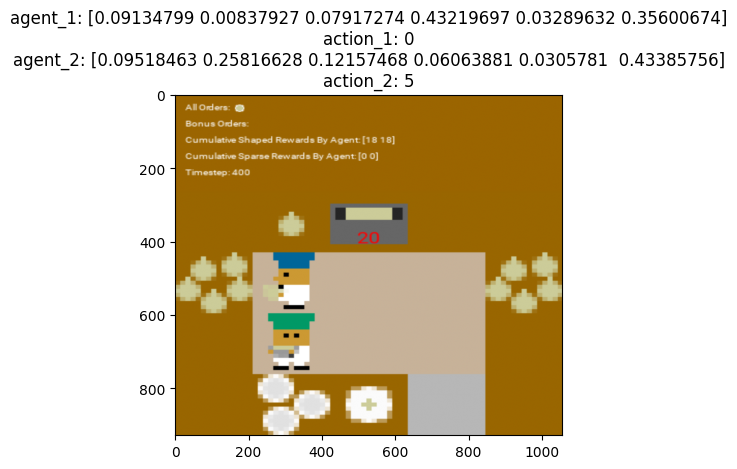

In [478]:
action1 = agent_1.action(obs['both_agent_obs'])
action2 = agent_2.action(obs['both_agent_obs'])
player_1_action = Action.ACTION_TO_INDEX[action1[0]]
player_2_action = Action.ACTION_TO_INDEX[action2[0]]
action = (player_1_action, player_2_action)

action_probs = shared_actor.call(obs['both_agent_obs'])

plt.figure(figsize=(5,5))
plt.title(f"agent_1: {np.squeeze(action_probs[0].numpy())}\n"
          f"action_1: {player_1_action}\n"
          f"agent_2: {np.squeeze(action_probs[1].numpy())}\n"
          f"action_2: {player_2_action}")
          
img = env.render() / 255
plt.imshow(img)

new_obs, reward, done, env_info = env.step(action)
shaped_reward = sum(env_info['shaped_r_by_agent']) # let's use shaped reward for learning how to play first.

total_reward = reward + shaped_reward

cumulative_reward += total_reward

# update state (obs = new_obs)
obs = new_obs

# think about training the critic by itself for a while
t += 1

full simulation

In [ ]:
# Here we create an evaluator for the cramped_room layout
layout = "cramped_room"
ae = AgentEvaluator.from_layout_name(mdp_params={"layout_name": layout, "old_dynamics": True},
                                     env_params={"horizon": 400})

ap = AgentPair(agent_1, agent_2)

trajs = ae.evaluate_agent_pair(ap, 10)
# trajs = ae.evaluate_human_model_pair(1)

StateVisualizer().display_rendered_trajectory(trajs, ipython_display=True)

Avg rew: 80.00 (std: 0.00, se: 0.00); avg len: 400.00; :  10%|█         | 1/10 [00:09<01:23,  9.24s/it]


KeyboardInterrupt: 

In [51]:
number_of_episodes = 1
number_of_epochs = 2 # prima era 4
batch_size = 20
average_reward = 0
best_avg = 0
previous_action_to_reward = 5
gamma = 0.95
avg_reward_list = []

try:
    for episode in range(1, number_of_episodes + 1):
        actions = []
        deltas = []
        observations = []

        t = 0
        obs = env.reset()
        obs = obs['both_agent_obs'] 
        
        done = False
        cumulative_reward = 0

        while not done:
            action1 = agent_1.action(obs)
            action2 = agent_2.action(obs)
            player_1_action = Action.ACTION_TO_INDEX[action1[0]]
            player_2_action = Action.ACTION_TO_INDEX[action2[0]]
            action = (player_1_action, player_2_action)

            actions.append(action)
            observations.append(obs)

            new_obs, reward, done, env_info = env.step(action)
            shaped_reward = sum(env_info['shaped_r_by_agent']) # let's use shaped reward for learning how to play first.

            new_obs = new_obs['both_agent_obs']

            total_reward = reward + shaped_reward

            cumulative_reward += total_reward

            if total_reward > 0 and episode < 3500:
                if t > previous_action_to_reward:
                    for i in range(t-1, t-previous_action_to_reward-1, -1):
                        deltas[i] += total_reward
                else:
                    for i in range(t-1,-1,-1):
                        deltas[i] += total_reward

            # compute delta = R + v^(St+1) - v^(St) where v^(St+1) = 0 if done
            if done:
                delta = total_reward - shared_critic.call(obs)
            else:
                delta = total_reward + gamma*shared_critic.call(new_obs) - shared_critic.call(obs)

            deltas.append(delta)
            
            # update state (obs = new_obs)
            obs = new_obs

            # think about training the critic by itself for a while
            t += 1

        average_reward = 1/(episode)*( cumulative_reward + (episode-1)*average_reward)
        avg_reward_list.append(average_reward)

        if average_reward > best_avg and episode > 20:
            best_avg = average_reward
            shared_critic.save_weights(path_critic)
            shared_actor.save_weights(path_actor)

        print(f"Episode [{episode:>3d}] terminated at timestep {t}. cumulative reward: {cumulative_reward:>3d}. avg reward: {round(average_reward, 3)}")
        print(f"Performing stocastic gradient descent with {number_of_epochs} epochs.")
        for epoch in range(1, number_of_epochs + 1):
            num_batches = len(actions) // batch_size
            shuffled_indices = tf.random.shuffle(tf.range(len(actions)))
            for batch in range(num_batches):
                if batch == num_batches: # last batch
                    idx = shuffled_indices[batch*batch_size:]
                else:
                    idx = shuffled_indices[batch*batch_size:(batch+1)*batch_size]

                deltas_batch = tf.squeeze(tf.gather(deltas, idx), axis=-1)
                actions_batch = tf.gather(actions, idx)
                observations_batch = tf.gather(observations, idx)

                shared_critic.train_batch(deltas_batch, observations_batch)
                shared_actor.train_batch(deltas_batch, observations_batch, actions_batch)
            print(f"Epoch {epoch} terminated.")

except KeyboardInterrupt:
    shared_critic.save_weights(path_critic)
    shared_actor.save_weights(path_actor)
    print("User interrupted training. Saving weights")

Episode [  1] terminated at timestep 400. cumulative reward:  17. avg reward: 17.0
Performing stocastic gradient descent with 2 epochs.
Epoch 1 terminated.
Epoch 2 terminated.


In [114]:
entropy_1 = tf.reduce_mean([scipy.stats.entropy(pi[0][i].numpy().tolist()) for i in range(len(pi[0]))])
entropy_2 = tf.reduce_mean([scipy.stats.entropy(pi[1][i].numpy().tolist()) for i in range(len(pi[1]))])
entropy_loss = (entropy_1.numpy() + entropy_2.numpy())*0.5
pi_a - entropy_loss

<tf.Tensor: shape=(), dtype=float32, numpy=-6.769484996795654>

In [71]:
shared_actor.load_weights("networks/actor/shared_actor_exp_6_final.weights.h5")
shared_critic.load_weights("networks/critic/shared_critic_exp_6_final.weights.h5")

In [12]:
t = 0
cumulative_reward = 0
obs = env.reset()
obs['other_agent_env_idx']

0

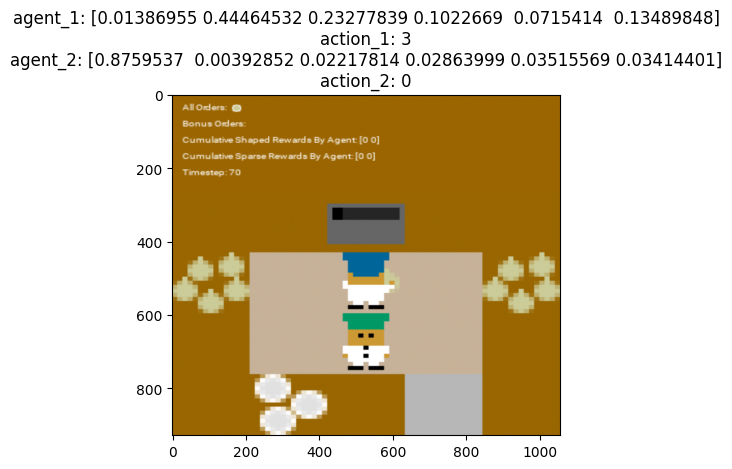

In [83]:
action1 = agent_1.action(obs['both_agent_obs'])
action2 = agent_2.action(obs['both_agent_obs'])
player_1_action = Action.ACTION_TO_INDEX[action1[0]]
player_2_action = Action.ACTION_TO_INDEX[action2[0]]
action = (player_1_action, player_2_action)

action_probs = shared_actor.call(obs['both_agent_obs'])

plt.figure(figsize=(5,5))
plt.title(f"agent_1: {np.squeeze(action_probs[0].numpy())}\n"
          f"action_1: {player_1_action}\n"
          f"agent_2: {np.squeeze(action_probs[1].numpy())}\n"
          f"action_2: {player_2_action}")
          
img = env.render() / 255
plt.imshow(img)

new_obs, reward, done, env_info = env.step(action)
shaped_reward = sum(env_info['shaped_r_by_agent']) # let's use shaped reward for learning how to play first.

total_reward = reward + shaped_reward

cumulative_reward += total_reward

# update state (obs = new_obs)
obs = new_obs

# think about training the critic by itself for a while
t += 1

In [12]:
# Here we create an evaluator for the cramped_room layout
layout = "cramped_room"
ae = AgentEvaluator.from_layout_name(mdp_params={"layout_name": layout, "old_dynamics": True},
                                     env_params={"horizon": 400})

ap = AgentPair(agent_1, agent_2)

trajs = ae.evaluate_agent_pair(ap, 1)
# trajs = ae.evaluate_human_model_pair(1)

StateVisualizer().display_rendered_trajectory(trajs, ipython_display=True)

Avg rew: 0.00 (std: 0.00, se: 0.00); avg len: 400.00; : 100%|██████████| 1/1 [00:07<00:00,  7.95s/it]


interactive(children=(IntSlider(value=0, description='timestep', max=399), Output()), _dom_classes=('widget-in…

In [499]:
import json
PATH_EXPERIMENT_INFO = "info/ac_exp_7.json"
with open(PATH_EXPERIMENT_INFO, 'r') as f:
    experiment_info_exp_7 = json.load(f)
    print("Experiment's info loaded.")

Experiment's info loaded.


In [503]:
len(experiment_info_exp_3["avg_reward_list"])

6823

In [251]:
avg_reward_list_2 = experiment_info["avg_reward_list"]

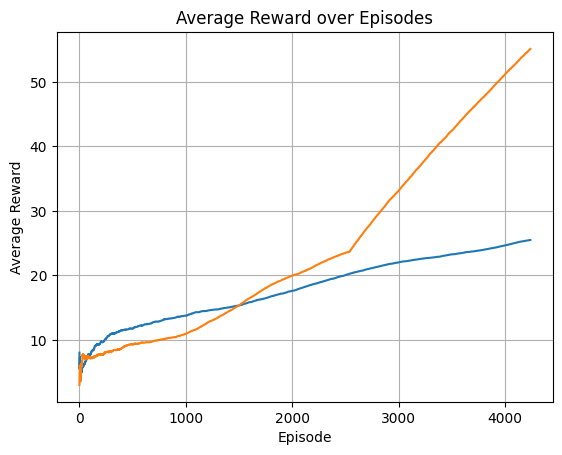

In [506]:
avg_reward_list_exp_3 = experiment_info_exp_3["avg_reward_list"]
avg_reward_list_exp_7 = experiment_info_exp_7["avg_reward_list"]
num_episodes = min(len(avg_reward_list_exp_3),len(avg_reward_list_exp_7))
# plot the average reward over the episodes
import matplotlib.pyplot as plt
plt.plot(range(num_episodes), avg_reward_list_exp_3[:num_episodes])
plt.plot(range(num_episodes), avg_reward_list_exp_7[:num_episodes])
# plt.plot(range(1, number_of_episodes + 1), avg_reward_list_PPO)
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title('Average Reward over Episodes')
plt.grid()
plt.show()

In [253]:
avg_reward_list_2[3999]

24.65

In [514]:
len(avg_reward_list) - 3982 + 2400

3418

In [ ]:
with tf.GradientTape() as tape:
    pi = shared_actor.call(obs_batch, training=True)
    log_pi = tf.math.log(pi)
    pi_a1 = tf.gather(log_pi[0], actions_batch[:, 0], axis=1, batch_dims=1)
    pi_a2 = tf.gather(log_pi[1], actions_batch[:, 1], axis=1, batch_dims=1)
    stacked_pi_a = tf.stack((pi_a1,pi_a2), axis=1)
    # Now compute the weighted sum over the batch
    pi_a = tf.reduce_sum(-deltas_batch*stacked_pi_a)
    # pi_a = -tf.reduce_sum(tf.squeeze(deltas_batch) * (pi_a1 + pi_a2))

# grad_pi_a = tape.gradient(pi_a, self.trainable_weights)
# self.optimizer.apply_gradients(zip(grad_pi_a, self.trainable_weights))
deltas_batch

<tf.Tensor: shape=(20, 2), dtype=float32, numpy=
array([[-0.01013684,  0.2601894 ],
       [-0.489128  ,  0.64492774],
       [ 0.16762164, -0.12126122],
       [ 0.00376903, -0.00247864],
       [ 0.48980606,  0.25797147],
       [ 0.02107823,  0.05314092],
       [ 0.15986824,  0.04345089],
       [-0.00757484,  0.21013245],
       [-0.15626049,  0.06968173],
       [ 0.11993384, -0.100647  ],
       [ 0.07006839,  0.13852072],
       [ 0.115327  , -0.01494978],
       [ 0.00376903, -0.00247864],
       [ 0.17978138,  0.31218326],
       [ 0.00376903, -0.00247864],
       [ 0.04889929, -0.00665556],
       [ 0.1027571 , -0.16652115],
       [ 0.26723683,  0.37204126],
       [ 0.05336618, -0.00623512],
       [-0.12780945,  0.02695632]], dtype=float32)>

In [909]:
# stacked_pi_a = tf.stack((pi_a1,pi_a2), axis=1)
tf.reduce_sum(-deltas_batch*stacked_pi_a)

<tf.Tensor: shape=(), dtype=float32, numpy=5.568080425262451>

# Trial with batches and past reward, different deltas and critics.

In [6]:
number_of_frames = 400
layout_name = "cramped_room"
base_mdp = OvercookedGridworld.from_layout_name(layout_name=layout_name) #or other layout
base_env = OvercookedEnv.from_mdp(base_mdp, info_level=0, horizon=number_of_frames)
env = Overcooked(base_env=base_env, featurize_fn=base_env.featurize_state_mdp)

In [7]:
alpha_w = 1e-5
alpha_t = 1e-6
critic_1_optimizer = Adam(learning_rate=alpha_w)
critic_2_optimizer = Adam(learning_rate=alpha_w)
actor_optimizer = Adam(learning_rate=alpha_t)

In [8]:
input_shape = env.observation_space._shape

shared_actor = Policy(
    input_shape=input_shape,
    num_actions=Action.NUM_ACTIONS,
    optimizer=actor_optimizer
    )

critic_1 = ValueFunctionApproximator(
    input_shape=input_shape,
    optimizer=critic_1_optimizer
    )

critic_2 = ValueFunctionApproximator(
    input_shape=input_shape,
    optimizer=critic_2_optimizer
    )

In [9]:
agent_1 = MyAgent(
    actor=shared_actor,
    old_policy=None,
    critic=critic_1,
    idx=0,
    base_env=base_env,
)
agent_2 = MyAgent(
    actor=shared_actor,
    old_policy=None,
    critic=critic_2,
    idx=1,
    base_env=base_env,
)

In [ ]:
path_critic_1 = "networks/critic/critic_ac_exp_2.weights.h5"
path_critic_2 = "networks/second_critic/second_critic_ac_exp_2.weights.h5"
path_actor = "networks/actor/actor_ac_exp_2.weights.h5"

In [620]:
shared_actor.load_weights(path_actor)
critic_1.load_weights(path_critic_1)
critic_2.load_weights(path_critic_2)

In [544]:
number_of_episodes = 1
number_of_epochs = 2 # prima era 4
batch_size = 20
average_reward = 0
best_avg = 0
previous_action_to_reward = 5
gamma = 0.95
avg_reward_list = []

try:
    for episode in range(1, number_of_episodes + 1):
        actions = []
        deltas = []
        observations = []
        rewards = []

        t = 0
        obs = env.reset()
        obs = obs['both_agent_obs'] 
        
        done = False
        cumulative_reward = 0

        while not done:
            action1 = agent_1.action(obs)
            action2 = agent_2.action(obs)
            player_1_action = Action.ACTION_TO_INDEX[action1[0]]
            player_2_action = Action.ACTION_TO_INDEX[action2[0]]
            action = (player_1_action, player_2_action)

            actions.append(action)
            observations.append(obs)

            new_obs, reward, done, env_info = env.step(action)
            # shaped_reward = sum(env_info['shaped_r_by_agent']) # let's use shaped reward for learning how to play first.
            shaped_reward_1 = env_info['shaped_r_by_agent'][0] 
            shaped_reward_2 = env_info['shaped_r_by_agent'][1] 

            sparse_reward_1 = env_info['sparse_r_by_agent'][0]
            sparse_reward_2 = env_info['sparse_r_by_agent'][1]

            total_reward_1 = shaped_reward_1 + sparse_reward_1
            total_reward_2 = shaped_reward_2 + sparse_reward_2

            new_obs = new_obs['both_agent_obs']

            # total_reward = reward + shaped_reward
            total_reward = total_reward_1 + total_reward_2

            cumulative_reward += total_reward

            rewards.append([total_reward_1, total_reward_2])


            # compute delta = R + v^(St+1) - v^(St) where v^(St+1) = 0 if done
            if done:
                delta_1 = total_reward_1 - critic_1.call(obs)
                delta_2 = total_reward_2 - critic_2.call(obs)
            else:
                delta_1 = total_reward_1 + gamma*critic_1.call(new_obs) - critic_1.call(obs)
                delta_2 = total_reward_2 + gamma*critic_2.call(new_obs) - critic_2.call(obs)

            deltas.append([delta_1,delta_2])
            
            if episode < 3500:
                if total_reward_1 > 0:
                    if t > previous_action_to_reward:
                        for i in range(t-1, t-previous_action_to_reward-1, -1):
                            deltas[i][0] += total_reward_1
                            rewards[i][0] += total_reward_1
                    else:
                        for i in range(t-1,-1,-1):
                            deltas[i][0] += total_reward_1
                            rewards[i][0] += total_reward_1
                if total_reward_2 > 0:
                    if t > previous_action_to_reward:
                        for i in range(t-1, t-previous_action_to_reward-1, -1):
                            deltas[i][1] += total_reward_2
                            rewards[i][1] += total_reward_2
                    else:
                        for i in range(t-1,-1,-1):
                            deltas[i][1] += total_reward_2
                            rewards[i][1] += total_reward_2

            # update state (obs = new_obs)
            obs = new_obs

            # think about training the critic by itself for a while
            t += 1

        average_reward = 1/(episode)*( cumulative_reward + (episode-1)*average_reward)
        avg_reward_list.append(average_reward)

        critic_values_1 = tf.squeeze(critic_1.call(observations))
        critic_values_2 = tf.squeeze(critic_2.call(observations))
        critic_values = tf.stack([critic_values_1,critic_values_2], axis=1)
        new_critic_values_1 = tf.squeeze(critic_1.call(observations[1:])) # it represent the estimation of the next observation
        new_critic_values_2 = tf.squeeze(critic_2.call(observations[1:])) # it represent the estimation of the next observation
        new_critic_values_1 = tf.concat([new_critic_values_1, tf.constant([0.0])], axis=0) # the last one is 0
        new_critic_values_2 = tf.concat([new_critic_values_2, tf.constant([0.0])], axis=0) # the last one is 0
        new_critic_values = tf.stack([new_critic_values_1,new_critic_values_2], axis=1)
        new_deltas = rewards + gamma*new_critic_values - critic_values

        # if average_reward > best_avg and episode > 20:
        #     best_avg = average_reward
        #     critic_1.save_weights(path_critic_1)
        #     critic_2.save_weights(path_critic_2)
        #     shared_actor.save_weights(path_actor)



        print(f"Episode [{episode:>3d}] terminated at timestep {t}. cumulative reward: {cumulative_reward:>3d}. avg reward: {round(average_reward, 3)}")
        # print(f"Performing stocastic gradient descent with {number_of_epochs} epochs.")
        # for epoch in range(1, number_of_epochs + 1):
        #     num_batches = len(actions) // batch_size
        #     shuffled_indices = tf.random.shuffle(tf.range(len(actions)))
        #     for batch in range(num_batches):
        #         if batch == num_batches: # last batch
        #             idx = shuffled_indices[batch*batch_size:]
        #         else:
        #             idx = shuffled_indices[batch*batch_size:(batch+1)*batch_size]

        #         deltas_batch = tf.squeeze(tf.gather(deltas, idx)) # HERE THERE IS NO AXIS IN THE SQUEEZE.
        #         deltas_batch_1 = tf.expand_dims(deltas_batch[:,0], axis=-1)
        #         deltas_batch_2 = tf.expand_dims(deltas_batch[:,1], axis=-1)

        #         actions_batch = tf.gather(actions, idx)
        #         observations_batch = tf.gather(observations, idx)

        #         critic_1.train_batch(deltas_batch_1, observations_batch)
        #         critic_2.train_batch(deltas_batch_2, observations_batch)
        #         shared_actor.train_batch(deltas_batch, observations_batch, actions_batch)
        #     print(f"Epoch {epoch} terminated.")

except KeyboardInterrupt:
    # critic_1.save_weights(path_critic_1)
    # critic_2.save_weights(path_critic_2)
    # shared_actor.save_weights(path_actor)
    print("User interrupted training. Saving weights")

Episode [  1] terminated at timestep 400. cumulative reward:  17. avg reward: 17.0


In [757]:
iteratore = iter(range(180, len(observations)))

In [762]:
idx = next(iteratore)
print(f"idx: {idx}")
print(new_deltas[idx][0].numpy())
print(deltas[idx][0].numpy()[0][0])
print("")
print(new_deltas[idx][1].numpy())
print(deltas[idx][1].numpy()[0][0])

idx: 184
-0.14915037
-0.14915037

-0.13783646
-0.13783646


In [774]:
idx = [i for i in range(20)]
print(tf.squeeze(tf.gather(deltas, idx)))
print(tf.gather(new_deltas, idx))

tf.Tensor(
[[-0.10413194 -0.09391594]
 [-0.10413194 -0.09391594]
 [-0.5425825  -0.43471527]
 [-0.08105564 -0.07597911]
 [-0.08105564 -0.07597911]
 [-0.02134454 -0.10065186]
 [-0.08419836 -0.07468057]
 [ 0.5452714   0.60990644]
 [ 0.0150044  -0.29679608]
 [-0.08905745 -0.10175812]
 [-0.06866407  0.05894589]
 [-0.07514358  2.92351   ]
 [ 0.12343001  3.0681334 ]
 [-0.05288291  3.0200908 ]
 [-0.24291229  2.7316337 ]
 [-0.07885742  2.8574228 ]
 [-1.1483699   2.1408875 ]
 [-0.16485548 -0.08542204]
 [ 2.907238   -0.08006787]
 [ 2.9757266  -0.07498145]], shape=(20, 2), dtype=float32)
tf.Tensor(
[[-0.10413194 -0.09391594]
 [-0.10413194 -0.09391594]
 [-0.5425819  -0.43471527]
 [-0.08105564 -0.07597911]
 [-0.08105564 -0.07597911]
 [-0.02134418 -0.10065186]
 [-0.08419836 -0.07468057]
 [ 0.54527164  0.6099069 ]
 [ 0.01500392 -0.29679608]
 [-0.08905768 -0.10175931]
 [-0.0686636   0.05894613]
 [-0.07514429  2.92351   ]
 [ 0.12343049  3.0681343 ]
 [-0.05288386  3.02009   ]
 [-0.24291158  2.7316341 ]
 

In [816]:
tf.stack([deltas_batch,deltas_batch], axis=1)
# tf.expand_dims(deltas_batch, axis=1)

<tf.Tensor: shape=(20, 2), dtype=float32, numpy=
array([[-0.67819786, -0.67819786],
       [-0.3686595 , -0.3686595 ],
       [-3.2926445 , -3.2926445 ],
       [-0.71593237, -0.71593237],
       [-0.24159479, -0.24159479],
       [-0.6684847 , -0.6684847 ],
       [-0.24159479, -0.24159479],
       [-0.6967945 , -0.6967945 ],
       [-0.5597286 , -0.5597286 ],
       [-0.24159479, -0.24159479],
       [-0.6952114 , -0.6952114 ],
       [-0.6671457 , -0.6671457 ],
       [ 0.43216658,  0.43216658],
       [-0.28486967, -0.28486967],
       [-0.0391674 , -0.0391674 ],
       [-0.35439444, -0.35439444],
       [ 4.3696594 ,  4.3696594 ],
       [ 2.3375654 ,  2.3375654 ],
       [-0.23642397, -0.23642397],
       [-0.24159479, -0.24159479]], dtype=float32)>

# Studying the execution time. IMPROVED VERSION

In [775]:
import time

In [776]:
number_of_frames = 400
layout_name = "cramped_room"
base_mdp = OvercookedGridworld.from_layout_name(layout_name=layout_name) #or other layout
base_env = OvercookedEnv.from_mdp(base_mdp, info_level=0, horizon=number_of_frames)
env = Overcooked(base_env=base_env, featurize_fn=base_env.featurize_state_mdp)

In [777]:
alpha_w = 1e-5
alpha_t = 1e-6
critic_optimizer = Adam(learning_rate=alpha_w)
actor_optimizer = Adam(learning_rate=alpha_t)

In [778]:
input_shape = env.observation_space._shape

shared_actor = Policy(
    input_shape=input_shape,
    num_actions=Action.NUM_ACTIONS,
    optimizer=actor_optimizer
    )

shared_critic = ValueFunctionApproximator(
    input_shape=input_shape,
    optimizer=critic_optimizer
    )

In [779]:
agent_1 = MyAgent(
    actor=shared_actor,
    old_policy=None,
    critic=shared_critic,
    idx=0,
    base_env=base_env,
)
agent_2 = MyAgent(
    actor=shared_actor,
    old_policy=None,
    critic=shared_critic,
    idx=1,
    base_env=base_env,
)

In [785]:
path_critic = "networks/critic/shared_critic_best_3.weights.h5"
path_actor = "networks/actor/shared_actor_best_3.weights.h5"

In [786]:
shared_actor.load_weights(path_actor)
shared_critic.load_weights(path_critic)

In [782]:
save = False

In [ ]:
number_of_episodes = 10
number_of_epochs = 2 # prima era 4
batch_size = 20
average_reward = 0
best_avg = 0
previous_action_to_reward = 5
gamma = 0.95
avg_reward_list = []

for episode in range(1, number_of_episodes + 1):
    actions = []
    # deltas_as_is = []
    observations = []
    rewards = []

    t = 0
    obs = env.reset()
    obs = obs['both_agent_obs'] 
    
    done = False
    cumulative_reward = 0

    start_episode = time.time()

    while not done:
        action1 = agent_1.action(obs)
        action2 = agent_2.action(obs)
        player_1_action = Action.ACTION_TO_INDEX[action1[0]]
        player_2_action = Action.ACTION_TO_INDEX[action2[0]]
        action = (player_1_action, player_2_action)

        actions.append(action)
        observations.append(obs)

        new_obs, reward, done, env_info = env.step(action)
        shaped_reward = sum(env_info['shaped_r_by_agent']) # let's use shaped reward for learning how to play first.
        
        sparse_reward = sum(env_info['sparse_r_by_agent']) # let's use shaped reward for learning how to play first.

        new_obs = new_obs['both_agent_obs']

        total_reward = reward + shaped_reward

        cumulative_reward += total_reward

        rewards.append(total_reward)

        if total_reward > 0 and episode < 3500:
            if t > previous_action_to_reward:
                for i in range(t-1, t-previous_action_to_reward-1, -1):
                    # deltas_as_is[i] += total_reward
                    rewards[i] += total_reward
            else:
                for i in range(t-1,-1,-1):
                    # deltas_as_is[i] += total_reward
                    rewards[i] += total_reward

        # compute delta = R + v^(St+1) - v^(St) where v^(St+1) = 0 if done
        # if done:
        #     delta = total_reward - shared_critic.call(obs)
        # else:
        #     delta = total_reward + gamma*shared_critic.call(new_obs) - shared_critic.call(obs)

        # deltas_as_is.append(delta)
        
        # update state (obs = new_obs)
        obs = new_obs

        # think about training the critic by itself for a while
        t += 1
    
    critic_values = tf.squeeze(shared_critic.call(observations))
    new_critic_values = tf.squeeze(shared_critic.call(observations[1:])) # it represent the estimation of the next observation
    new_critic_values = tf.concat([new_critic_values, tf.constant([0.0])], axis=0) # the last one is 0
    deltas = rewards + gamma*new_critic_values - critic_values

    average_reward = 1/(episode)*( cumulative_reward + (episode-1)*average_reward)
    avg_reward_list.append(average_reward)
    
    end_episode = time.time()

    if average_reward > best_avg and episode > 20 and save:
        best_avg = average_reward
        # shared_critic.save_weights(path_critic)
        # shared_actor.save_weights(path_actor)

    print(f"Episode [{episode:>3d}] terminated at timestep {t}." 
          f"cumulative reward: {cumulative_reward:>3d}. avg reward: {round(average_reward, 3)}"
          f"execution time: {round(end_episode - start_episode, 2)} seconds")
    
    # print(f"Performing stocastic gradient descent with {number_of_epochs} epochs.")
    # start_training = time.time()
    # for epoch in range(1, number_of_epochs + 1):
    #     num_batches = len(actions) // batch_size
    #     shuffled_indices = tf.random.shuffle(tf.range(len(actions)))
    #     for batch in range(num_batches):
    #         if batch == num_batches: # last batch
    #             idx = shuffled_indices[batch*batch_size:]
    #         else:
    #             idx = shuffled_indices[batch*batch_size:(batch+1)*batch_size]

    #         deltas_batch = tf.gather(deltas, idx)
    #         actions_batch = tf.gather(actions, idx)
    #         observations_batch = tf.gather(observations, idx)

    #         shared_critic.train_batch(deltas_batch, observations_batch)
    #         shared_actor.train_batch(deltas_batch, observations_batch, actions_batch)
    #     print(f"Epoch {epoch} terminated.")
    # end_training = time.time()
    # print(f"Training ended in {round(end_training - start_training, 2)} seconds")



reward: 20
sparse reward: 20
Episode [  1] terminated at timestep 400.cumulative reward:  56. avg reward: 56.0execution time: 5.18 seconds
reward: 20
sparse reward: 20
Episode [  2] terminated at timestep 400.cumulative reward: 107. avg reward: 81.5execution time: 5.22 seconds
reward: 20
sparse reward: 20
Episode [  3] terminated at timestep 400.cumulative reward:  43. avg reward: 68.667execution time: 6.82 seconds
Episode [  4] terminated at timestep 400.cumulative reward:   9. avg reward: 53.75execution time: 5.43 seconds
Episode [  5] terminated at timestep 400.cumulative reward:  44. avg reward: 51.8execution time: 5.79 seconds
Episode [  6] terminated at timestep 400.cumulative reward:  39. avg reward: 49.667execution time: 5.64 seconds
reward: 20
sparse reward: 20
Episode [  7] terminated at timestep 400.cumulative reward: 121. avg reward: 59.857execution time: 6.33 seconds
reward: 20
sparse reward: 20
Episode [  8] terminated at timestep 400.cumulative reward: 115. avg reward: 6

In [55]:
single_rewards = tf.stack([tf.constant(rewards, dtype=float), tf.constant(rewards, dtype=float)+1], axis=1)
single_critic_values = tf.stack([critic_values,critic_values], axis=1)
single_new_critic_values = tf.stack([new_critic_values,new_critic_values], axis=1)

In [65]:
single_rewards_list = [[reward, reward+1] for reward in rewards]

In [66]:
single_rewards_list + gamma*single_new_critic_values - single_critic_values

<tf.Tensor: shape=(400, 2), dtype=float32, numpy=
array([[ 2.09665203e+00,  3.09665203e+00],
       [-1.22956276e-01,  8.77043724e-01],
       [-6.74301147e-01,  3.25698853e-01],
       [ 2.21682549e-01,  1.22168255e+00],
       [-2.32704163e-01,  7.67295837e-01],
       [-6.62078857e-01,  3.37921143e-01],
       [-1.04992962e+00, -4.99296188e-02],
       [-2.19846344e+00, -1.19846344e+00],
       [-6.63928986e-01,  3.36071014e-01],
       [ 9.26250458e-01,  1.92625046e+00],
       [-6.03410721e-01,  3.96589279e-01],
       [ 6.55498505e-02,  1.06554985e+00],
       [-1.45338726e+00, -4.53387260e-01],
       [-8.30304146e-01,  1.69695854e-01],
       [ 2.38130569e+00,  3.38130569e+00],
       [ 2.38130569e+00,  3.38130569e+00],
       [ 2.58233547e+00,  3.58233547e+00],
       [ 3.08084869e+00,  4.08084869e+00],
       [ 2.32504845e+00,  3.32504749e+00],
       [ 1.97760963e+00,  2.97760963e+00],
       [-1.04137039e+00, -4.13703918e-02],
       [-6.51213646e-01,  3.48786354e-01],
    

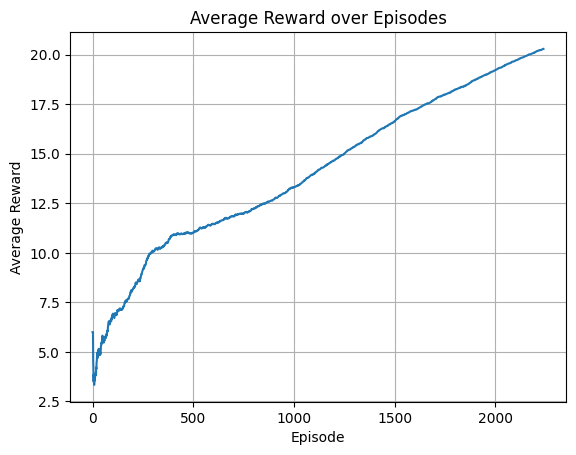

In [14]:
# plot the average reward over the episodes
import matplotlib.pyplot as plt
plt.plot(range(len(avg_reward_list)), avg_reward_list)
# plt.plot(range(1, number_of_episodes + 1), avg_reward_list_PPO)
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title('Average Reward over Episodes')
plt.grid()
plt.show()

In [14]:
# Here we create an evaluator for the cramped_room layout
layout = "cramped_room"
ae = AgentEvaluator.from_layout_name(mdp_params={"layout_name": layout, "old_dynamics": True},
                                     env_params={"horizon": 400})

ap = AgentPair(agent_1, agent_2)

trajs = ae.evaluate_agent_pair(ap, 1)
# trajs = ae.evaluate_human_model_pair(1)

StateVisualizer().display_rendered_trajectory(trajs, ipython_display=True)

Avg rew: 0.00 (std: 0.00, se: 0.00); avg len: 400.00; : 100%|██████████| 1/1 [00:06<00:00,  6.58s/it]


interactive(children=(IntSlider(value=0, description='timestep', max=399), Output()), _dom_classes=('widget-in…

In [63]:
delta_try = deltas
if tf.rank(deltas) == 1:
    delta_try = tf.expand_dims(deltas, axis=1)
delta_try

<tf.Tensor: shape=(400, 1), dtype=float32, numpy=
array([[-3.52311730e-02],
       [-5.57577431e-01],
       [ 1.49160489e-01],
       [-1.59971714e-02],
       [ 1.84763074e-02],
       [-3.66353095e-02],
       [ 5.20695448e-02],
       [ 1.37848407e-01],
       [-2.87779570e-02],
       [-1.94205195e-01],
       [-2.00712681e-02],
       [-2.00712681e-02],
       [-3.03046107e-02],
       [-1.95326507e-02],
       [ 1.03634566e-01],
       [-7.16374218e-02],
       [ 2.26568282e-01],
       [ 1.23352706e-01],
       [-4.52095866e-02],
       [-1.58728957e-01],
       [-3.99108142e-01],
       [-2.02941597e-02],
       [-1.37385726e-03],
       [-4.02102768e-02],
       [ 1.87552214e-01],
       [-2.52544552e-01],
       [-1.00366056e-01],
       [ 3.79393190e-01],
       [-3.61090302e-02],
       [ 1.40019357e-01],
       [-1.81473494e-02],
       [-4.21889782e-01],
       [ 2.31329501e-01],
       [-1.52235985e-01],
       [-2.13779032e-01],
       [ 1.17444634e-01],
       [-6.109

In [ ]:
# idx = [1,2,3,4,5,6,7,8]
# tf.squeeze(tf.gather(deltas_as_is, idx))
# tf.gather(new_deltas, idx)

<tf.Tensor: shape=(8,), dtype=float32, numpy=
array([-0.1757896 , -0.01921844, -0.16730261, -0.13584709, -0.15554738,
       -0.263613  ,  0.03708529,  0.15914583], dtype=float32)>

In [227]:
iteratore = iter(range(len(observations)))

In [ ]:
idx = next(iteratore)
print(f"idx: {idx}")
print(new_deltas[idx].numpy())
print(deltas_as_is[idx].numpy()[0][0])

StopIteration: 

# Studying the execution time. IMPROVED VERSION. PPO

In [84]:
import time

In [85]:
number_of_frames = 400
layout_name = "cramped_room"
base_mdp = OvercookedGridworld.from_layout_name(layout_name=layout_name) #or other layout
base_env = OvercookedEnv.from_mdp(base_mdp, info_level=0, horizon=number_of_frames)
env = Overcooked(base_env=base_env, featurize_fn=base_env.featurize_state_mdp)

In [ ]:
alpha_w = 1e-5
alpha_t = 1e-6
critic_optimizer = Adam(learning_rate=alpha_w)
actor_optimizer = Adam(learning_rate=alpha_t)

In [71]:
input_shape = env.observation_space._shape

shared_actor = Policy(
    input_shape=input_shape,
    num_actions=Action.NUM_ACTIONS,
    optimizer=actor_optimizer
    )

shared_old_policy = Policy(
    input_shape=input_shape,
    num_actions=Action.NUM_ACTIONS,
    optimizer=actor_optimizer
    )


shared_critic = ValueFunctionApproximator(
    input_shape=input_shape,
    optimizer=critic_optimizer
    )

In [72]:
agent_1 = MyAgent(
    actor=shared_actor,
    old_policy=shared_old_policy,
    critic=shared_critic,
    idx=0,
    base_env=base_env,
)
agent_2 = MyAgent(
    actor=shared_actor,
    old_policy=shared_old_policy,
    critic=shared_critic,
    idx=1,
    base_env=base_env,
)

In [73]:
agent_1.update_old_policy()

In [ ]:
number_of_episodes = 1
number_of_epochs = 2 # prima era 4
batch_size = 20
average_reward = 0
best_avg = 0
previous_action_to_reward = 5
gamma = 0.95
avg_reward_list = []
episode_times = []
training_times = []

for episode in range(1, number_of_episodes + 1):
    actions = []
    # deltas_as_is = []
    observations = []
    rewards = []

    t = 0
    obs = env.reset()
    obs = obs['both_agent_obs'] 
    
    done = False
    cumulative_reward = 0

    start_episode = time.time()

    while not done:
        action1 = agent_1.action(obs)
        action2 = agent_2.action(obs)
        player_1_action = Action.ACTION_TO_INDEX[action1[0]]
        player_2_action = Action.ACTION_TO_INDEX[action2[0]]
        action = (player_1_action, player_2_action)

        actions.append(action)
        observations.append(obs)

        new_obs, reward, done, env_info = env.step(action)
        shaped_reward = sum(env_info['shaped_r_by_agent']) # let's use shaped reward for learning how to play first.

        new_obs = new_obs['both_agent_obs']

        total_reward = reward + shaped_reward

        cumulative_reward += total_reward

        rewards.append(total_reward)

        if total_reward > 0 and episode < 3500:
            if t > previous_action_to_reward:
                for i in range(t-1, t-previous_action_to_reward-1, -1):
                    # deltas_as_is[i] += total_reward
                    rewards[i] += total_reward
            else:
                for i in range(t-1,-1,-1):
                    # deltas_as_is[i] += total_reward
                    rewards[i] += total_reward

        # compute delta = R + v^(St+1) - v^(St) where v^(St+1) = 0 if done
        # if done:
        #     delta = total_reward - shared_critic.call(obs)
        # else:
        #     delta = total_reward + gamma*shared_critic.call(new_obs) - shared_critic.call(obs)

        # deltas_as_is.append(delta)
        
        # update state (obs = new_obs)
        obs = new_obs

        # think about training the critic by itself for a while
        t += 1
    
    critic_values = tf.squeeze(shared_critic.call(observations))
    new_critic_values = tf.squeeze(shared_critic.call(observations[1:])) # it represent the estimation of the next observation
    new_critic_values = tf.concat([new_critic_values, tf.constant([0.0])], axis=0) # the last one is 0
    deltas = rewards + gamma*new_critic_values - critic_values

    average_reward = 1/(episode)*( cumulative_reward + (episode-1)*average_reward)
    avg_reward_list.append(average_reward)
    
    end_episode = time.time()

    print(f"Episode [{episode:>3d}] terminated at timestep {t}." 
          f"cumulative reward: {cumulative_reward:>3d}. avg reward: {round(average_reward, 3)}"
          f"execution time: {round(end_episode - start_episode, 2)} seconds")
    
    episode_times.append(round(end_episode - start_episode, 2))
    
    print(f"Performing stocastic gradient descent with {number_of_epochs} epochs.")
    start_training = time.time()
    for epoch in range(1, number_of_epochs + 1):
        num_batches = len(actions) // batch_size
        shuffled_indices = tf.random.shuffle(tf.range(len(actions)))
        for batch in range(num_batches):
            if batch == num_batches: # last batch
                idx = shuffled_indices[batch*batch_size:]
            else:
                idx = shuffled_indices[batch*batch_size:(batch+1)*batch_size]

            deltas_batch = tf.gather(deltas, idx)
            actions_batch = tf.gather(actions, idx)
            observations_batch = tf.gather(observations, idx)

            shared_critic.train_batch(deltas_batch, observations_batch)
            shared_actor.train_batch_PPO(deltas_batch, observations_batch, actions_batch, shared_old_policy)
        print(f"Epoch {epoch} terminated.")
    agent_1.update_old_policy()
    end_training = time.time()
    print(f"Training ended in {round(end_training - start_training, 2)} seconds")
    training_times.append(round(end_training - start_training, 2))
print(f"average episode time: {sum(episode_times)/len(episode_times)}")
print(f"average training time: {sum(training_times)/len(training_times)}")


Episode [  1] terminated at timestep 400.cumulative reward:   9. avg reward: 9.0execution time: 6.34 seconds
Performing stocastic gradient descent with 2 epochs.
Epoch 1 terminated.
Epoch 2 terminated.
Training ended in 11.05 seconds
average episode time: 6.34
average training time: 11.05
